In [36]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')

from sklearn.preprocessing import StandardScaler
import datetime
import os
import zipfile
import warnings
warnings.filterwarnings("ignore")
# import wtphm

#machine learning
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from group_lasso import LogisticGroupLasso
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
from scipy.sparse.linalg import lsqr
from scipy.linalg import eigh

# local modules
import wind_turbine_fault_detection.dataset as get
import wind_turbine_fault_detection.features as feat
import wind_turbine_fault_detection.plots as plots

In [2]:
# auto reload modules
%load_ext autoreload
%autoreload 2

For the anomaly detection data sets, each file in `Wind Farm {}/datasets` represents an individual turbine.

In [3]:
guck = get.Guck_et_al("All", verbose=True)
all_wind_farms = guck.get_data(collect=False)

Project root: C:\Users\nehem\OneDrive\Documents\GitHub\Wind Turbine Fault Detection
Resolved base data path: C:\Users\nehem\OneDrive\Documents\GitHub\Wind Turbine Fault Detection\data\raw
Importing data for wind farm: ALL
Starting import for wind farm A
Starting import for wind farm B
Starting import for wind farm C


In [4]:
all_wind_farms.keys()

dict_keys(['A', 'B', 'C'])

In [5]:
wind_farm_a, wind_farm_b, wind_farm_c = all_wind_farms['A'], all_wind_farms['B'], all_wind_farms['C']

In [6]:
# Using a lazy DataFrame
lazy_df = wind_farm_a['dataset_10']
# And to use the data, just call collect():
example = lazy_df.filter(pl.col('wind_speed_3_avg') > 5).collect()
print(example.head())
del example

shape: (5, 87)
┌─────────────┬──────────┬─────┬────────────┬───┬─────────────┬────────────┬────────────┬──────────┐
│ time_stamp  ┆ asset_id ┆ id  ┆ train_test ┆ … ┆ sensor_52_m ┆ sensor_52_ ┆ sensor_53_ ┆ event_id │
│ ---         ┆ ---      ┆ --- ┆ ---        ┆   ┆ in          ┆ std        ┆ avg        ┆ ---      │
│ datetime[μs ┆ i64      ┆ i64 ┆ str        ┆   ┆ ---         ┆ ---        ┆ ---        ┆ i64      │
│ ]           ┆          ┆     ┆            ┆   ┆ f64         ┆ f64        ┆ f64        ┆          │
╞═════════════╪══════════╪═════╪════════════╪═══╪═════════════╪════════════╪════════════╪══════════╡
│ 2013-10-10  ┆ 10       ┆ 22  ┆ train      ┆ … ┆ 10.8        ┆ 0.5        ┆ 28.0       ┆ 10       │
│ 12:20:00    ┆          ┆     ┆            ┆   ┆             ┆            ┆            ┆          │
│ 2013-10-10  ┆ 10       ┆ 23  ┆ train      ┆ … ┆ 11.1        ┆ 0.6        ┆ 28.0       ┆ 10       │
│ 12:30:00    ┆          ┆     ┆            ┆   ┆             ┆            ┆

We will define a list of parameters called normal_ops and fault_ops, which will help delineate between data operating under normal conditions and data that isn't.

In [7]:
normal_ops = [0, 2]
fault_ops = [1, 3, 4, 5]

In [8]:
# combine all datasets into a single dataframe
dataset_keys = [key for key in wind_farm_a.keys() if key.startswith('dataset_')]
df_id = []
for key in dataset_keys:
    df = wind_farm_a[key].collect()
    df_id.append(df)
    
wfa_df = pl.concat(df_id, how='vertical')
# move dataset_id to the second column
wfa_df = wfa_df.select([pl.col('time_stamp'), pl.col('event_id'), pl.all().exclude(['time_stamp', 'event_id'])])
# sort the dataframe by time_stamp
wfa_df = wfa_df.sort('time_stamp')

### Set up the mother of all datasets for wind farm A

In [9]:
# Create 'fault_status' column with 0 for normal and 1 for fault. Move to the second column
wfa_df = wfa_df.with_columns(
    pl.when(pl.col('status_type_id').is_in([1, 3, 4, 5]))
    .then(1)
    .otherwise(0)
    .alias('fault_status')
).select([pl.col('time_stamp'), pl.col('fault_status'), pl.all().exclude(['time_stamp', 'fault_status'])])
wfa_df.head()

time_stamp,fault_status,event_id,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,wind_speed_3_avg,wind_speed_4_avg,wind_speed_3_max,wind_speed_3_min,wind_speed_3_std,sensor_5_avg,sensor_5_max,sensor_5_min,sensor_5_std,sensor_6_avg,sensor_7_avg,sensor_8_avg,sensor_9_avg,sensor_10_avg,sensor_11_avg,sensor_12_avg,sensor_13_avg,sensor_14_avg,sensor_15_avg,sensor_16_avg,sensor_17_avg,sensor_18_avg,sensor_18_max,sensor_18_min,sensor_18_std,sensor_19_avg,sensor_20_avg,…,power_29_avg,power_29_max,power_29_min,power_29_std,power_30_avg,power_30_max,power_30_min,power_30_std,sensor_31_avg,sensor_31_max,sensor_31_min,sensor_31_std,sensor_32_avg,sensor_33_avg,sensor_34_avg,sensor_35_avg,sensor_36_avg,sensor_37_avg,sensor_38_avg,sensor_39_avg,sensor_40_avg,sensor_41_avg,sensor_42_avg,sensor_43_avg,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52_avg,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg
datetime[μs],i32,i64,i64,i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-10-10 08:40:00,0,10,10,0,"""train""",0,20.0,265.7,19.4,2.6,2.6,4.3,1.0,0.4,24.0,24.1,24.0,0.0,30.0,35.0,44.0,35.0,31.0,39.0,39.0,30.0,32.0,34.0,34.0,35.0,203.7,224.1,166.3,13.5,24.0,31.0,…,0.000976,0.017073,0.0,0.003171,-0.004,-0.003317,-0.013902,0.001707,-0.005707,-10.5,-25.4,2.1,401.6,399.7,398.1,31.0,32.0,32.0,69.0,70.0,64.0,49.0,246.3,29.0,-1371.0,0.0,0.0,-1946.0,0.0,0.0,-1371.0,-1946.0,1.8,2.0,0.0,0.2,23.0
2013-10-10 08:50:00,0,10,10,1,"""train""",0,20.0,244.9,-11.8,2.6,2.6,4.9,0.7,0.5,24.0,24.1,24.0,0.0,30.0,35.0,43.0,35.0,31.0,39.0,39.0,30.0,32.0,34.0,34.0,34.0,200.2,224.1,168.0,15.0,24.0,31.0,…,0.000878,0.01322,0.0,0.002732,-0.003854,-0.003268,-0.012098,0.001756,-0.005415,-10.5,-15.4,0.9,400.3,397.8,396.6,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,29.0,-1309.0,0.0,0.0,-1850.0,0.0,0.0,-1309.0,-1850.0,1.8,2.0,1.5,0.1,23.0
2013-10-10 09:00:00,0,10,10,2,"""train""",0,20.0,299.5,42.7,2.5,2.5,4.2,0.6,0.5,24.0,24.0,21.6,0.1,30.0,35.0,42.0,35.0,31.0,38.0,39.0,30.0,31.0,34.0,34.0,34.0,202.8,224.4,148.2,23.6,24.0,30.0,…,0.0,0.007415,0.0,0.000244,-0.004,-0.003268,-0.012341,0.001902,-0.005415,-10.6,-15.4,0.9,400.0,398.3,396.5,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1349.0,0.0,0.0,-1851.0,0.0,0.0,-1349.0,-1851.0,1.6,2.0,0.0,0.7,23.0
2013-10-10 09:10:00,0,10,10,3,"""train""",0,20.0,280.2,23.5,2.5,2.5,3.8,0.6,0.4,24.0,24.1,24.0,0.0,30.0,35.0,41.0,35.0,31.0,38.0,39.0,30.0,31.0,34.0,34.0,34.0,198.3,212.4,170.4,12.0,24.0,30.0,…,0.0,0.0,0.0,0.0,-0.003854,-0.003268,-0.012439,0.00161,-0.005317,-10.4,-15.3,0.8,398.3,397.0,395.0,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1326.0,0.0,0.0,-1824.0,0.0,0.0,-1326.0,-1824.0,1.7,1.9,1.5,0.1,23.0
2013-10-10 09:20:00,0,10,10,4,"""train""",0,20.0,281.1,24.3,2.7,2.7,4.2,0.9,0.3,24.0,24.0,24.0,0.0,30.0,35.0,40.0,35.0,31.0,38.0,39.0,30.0,31.0,33.0,34.0,34.0,217.4,233.4,205.2,7.9,24.0,30.0,…,0.000049,0.007951,0.0,0.000439,-0.003854,-0.003268,-0.012439,0.001707,-0.005366,-10.4,-15.3,0.9,399.1,397.9,395.9,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1324.0,0.0,0.0,-1838.0,0.0,0.0,-1324.0,-1838.0,1.9,2.1,1.8,0.1,23.0


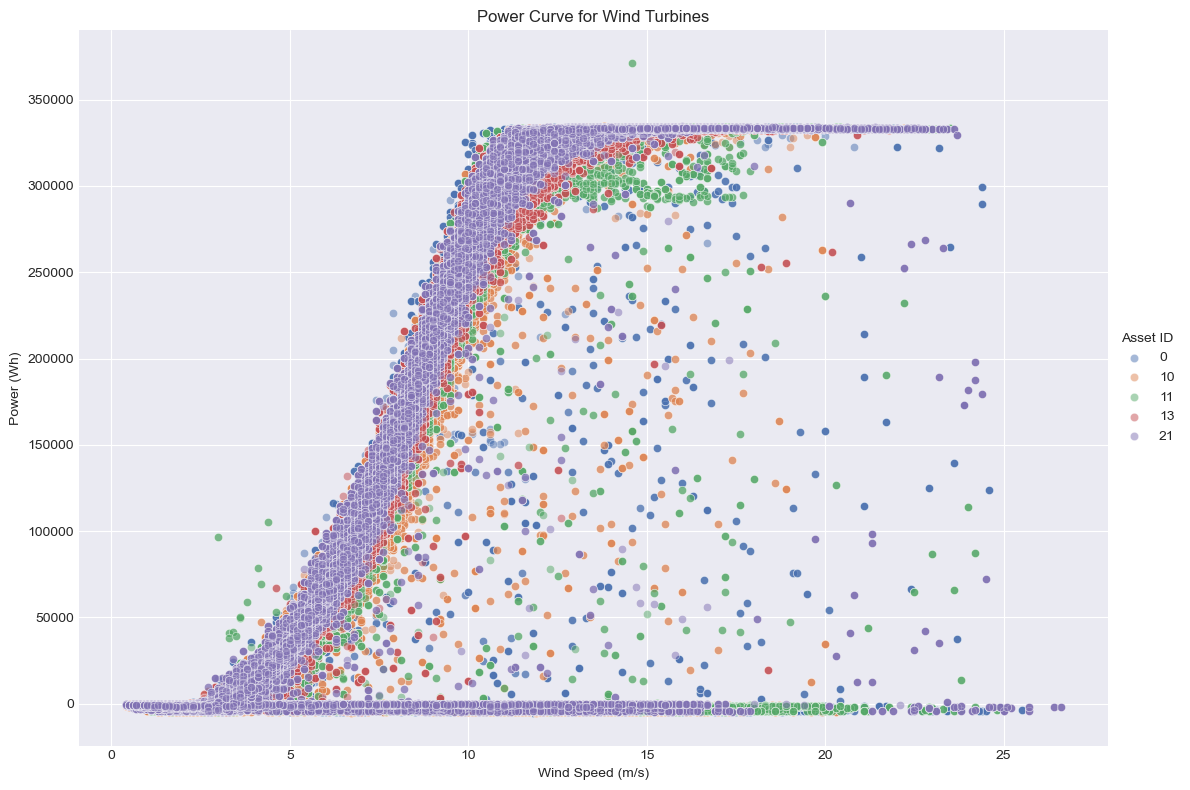

In [10]:
# Create the plot
plt.figure(figsize=(12, 8))

# Get unique asset IDs
asset_ids = wfa_df['asset_id'].unique().to_list()
colors = sns.color_palette("deep", n_colors=len(asset_ids))
# Plot for each asset
for asset_id, color in zip(asset_ids, colors):
    asset_data = wfa_df.filter(pl.col('asset_id') == asset_id)
    
    plt.scatter(
        asset_data['wind_speed_3_avg'], 
        asset_data['sensor_50'],  
        color=color,
        alpha=0.5,
        edgecolors='w', 
        linewidth=0.5,
        label=asset_id
    )

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (Wh)')
plt.title('Power Curve for Wind Turbines')
plt.legend(title='Asset ID', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()

## Exploratory Data Analysis

To perform EDA, I'll focus on the Asset 10 initially

In [11]:
wfa_wtg10 = wfa_df.filter(pl.col('asset_id') == 10)
wfa_wtg10.head()

time_stamp,fault_status,event_id,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,wind_speed_3_avg,wind_speed_4_avg,wind_speed_3_max,wind_speed_3_min,wind_speed_3_std,sensor_5_avg,sensor_5_max,sensor_5_min,sensor_5_std,sensor_6_avg,sensor_7_avg,sensor_8_avg,sensor_9_avg,sensor_10_avg,sensor_11_avg,sensor_12_avg,sensor_13_avg,sensor_14_avg,sensor_15_avg,sensor_16_avg,sensor_17_avg,sensor_18_avg,sensor_18_max,sensor_18_min,sensor_18_std,sensor_19_avg,sensor_20_avg,…,power_29_avg,power_29_max,power_29_min,power_29_std,power_30_avg,power_30_max,power_30_min,power_30_std,sensor_31_avg,sensor_31_max,sensor_31_min,sensor_31_std,sensor_32_avg,sensor_33_avg,sensor_34_avg,sensor_35_avg,sensor_36_avg,sensor_37_avg,sensor_38_avg,sensor_39_avg,sensor_40_avg,sensor_41_avg,sensor_42_avg,sensor_43_avg,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52_avg,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg
datetime[μs],i32,i64,i64,i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-10-10 08:40:00,0,10,10,0,"""train""",0,20.0,265.7,19.4,2.6,2.6,4.3,1.0,0.4,24.0,24.1,24.0,0.0,30.0,35.0,44.0,35.0,31.0,39.0,39.0,30.0,32.0,34.0,34.0,35.0,203.7,224.1,166.3,13.5,24.0,31.0,…,0.000976,0.017073,0.0,0.003171,-0.004,-0.003317,-0.013902,0.001707,-0.005707,-10.5,-25.4,2.1,401.6,399.7,398.1,31.0,32.0,32.0,69.0,70.0,64.0,49.0,246.3,29.0,-1371.0,0.0,0.0,-1946.0,0.0,0.0,-1371.0,-1946.0,1.8,2.0,0.0,0.2,23.0
2013-10-10 08:50:00,0,10,10,1,"""train""",0,20.0,244.9,-11.8,2.6,2.6,4.9,0.7,0.5,24.0,24.1,24.0,0.0,30.0,35.0,43.0,35.0,31.0,39.0,39.0,30.0,32.0,34.0,34.0,34.0,200.2,224.1,168.0,15.0,24.0,31.0,…,0.000878,0.01322,0.0,0.002732,-0.003854,-0.003268,-0.012098,0.001756,-0.005415,-10.5,-15.4,0.9,400.3,397.8,396.6,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,29.0,-1309.0,0.0,0.0,-1850.0,0.0,0.0,-1309.0,-1850.0,1.8,2.0,1.5,0.1,23.0
2013-10-10 09:00:00,0,10,10,2,"""train""",0,20.0,299.5,42.7,2.5,2.5,4.2,0.6,0.5,24.0,24.0,21.6,0.1,30.0,35.0,42.0,35.0,31.0,38.0,39.0,30.0,31.0,34.0,34.0,34.0,202.8,224.4,148.2,23.6,24.0,30.0,…,0.0,0.007415,0.0,0.000244,-0.004,-0.003268,-0.012341,0.001902,-0.005415,-10.6,-15.4,0.9,400.0,398.3,396.5,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1349.0,0.0,0.0,-1851.0,0.0,0.0,-1349.0,-1851.0,1.6,2.0,0.0,0.7,23.0
2013-10-10 09:10:00,0,10,10,3,"""train""",0,20.0,280.2,23.5,2.5,2.5,3.8,0.6,0.4,24.0,24.1,24.0,0.0,30.0,35.0,41.0,35.0,31.0,38.0,39.0,30.0,31.0,34.0,34.0,34.0,198.3,212.4,170.4,12.0,24.0,30.0,…,0.0,0.0,0.0,0.0,-0.003854,-0.003268,-0.012439,0.00161,-0.005317,-10.4,-15.3,0.8,398.3,397.0,395.0,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1326.0,0.0,0.0,-1824.0,0.0,0.0,-1326.0,-1824.0,1.7,1.9,1.5,0.1,23.0
2013-10-10 09:20:00,0,10,10,4,"""train""",0,20.0,281.1,24.3,2.7,2.7,4.2,0.9,0.3,24.0,24.0,24.0,0.0,30.0,35.0,40.0,35.0,31.0,38.0,39.0,30.0,31.0,33.0,34.0,34.0,217.4,233.4,205.2,7.9,24.0,30.0,…,0.000049,0.007951,0.0,0.000439,-0.003854,-0.003268,-0.012439,0.001707,-0.005366,-10.4,-15.3,0.9,399.1,397.9,395.9,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1324.0,0.0,0.0,-1838.0,0.0,0.0,-1324.0,-1838.0,1.9,2.1,1.8,0.1,23.0


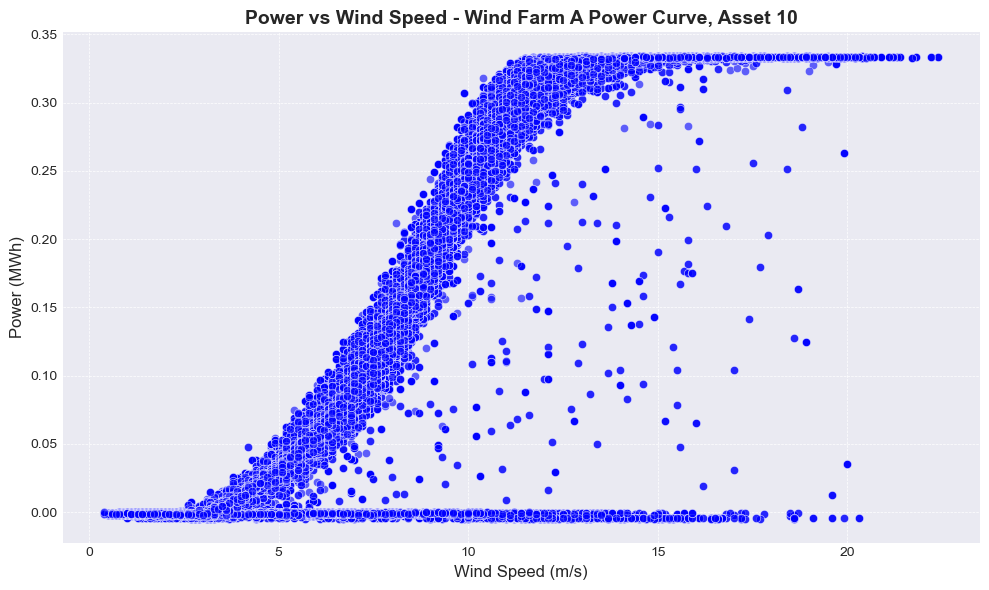

In [12]:
# Convert power from Wh to MWh for the y-axis using Polars
wfa_wtg10 = wfa_wtg10.with_columns(
    (pl.col('sensor_50') / 1e6).alias('sensor_50_mwh')
)

# Extract the necessary columns for plotting
wind_speed = wfa_wtg10['wind_speed_3_avg'].to_numpy()
power_mwh = wfa_wtg10['sensor_50_mwh'].to_numpy()

# Plot the power vs wind speed
plt.figure(figsize=(10, 6))
plt.scatter(wind_speed, power_mwh, color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)

# Enhancing the plot
plt.title('Power vs Wind Speed - Wind Farm A Power Curve, Asset 10', fontsize=14, fontweight='bold')
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power (MWh)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



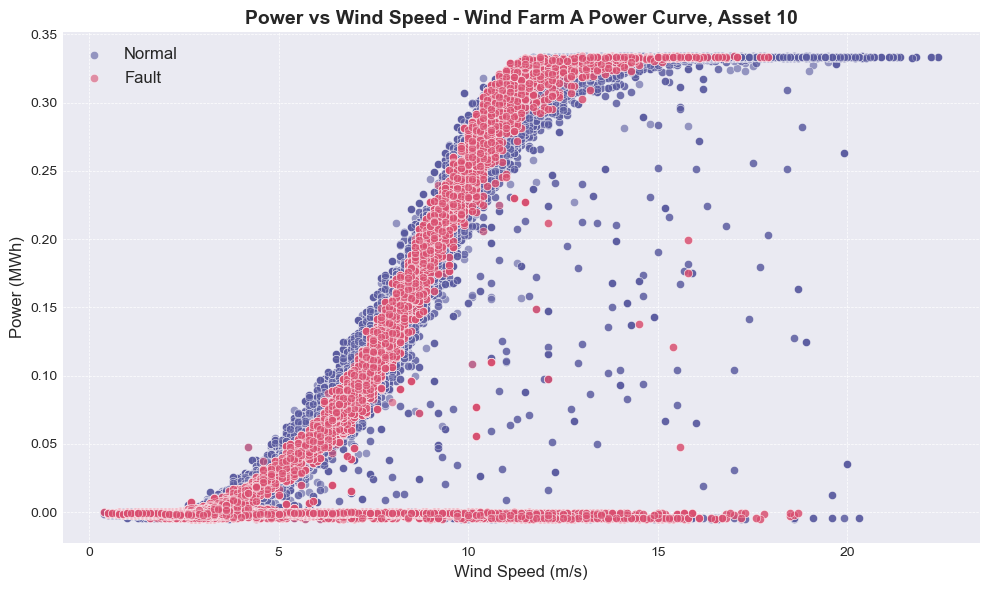

In [13]:
# Extract the necessary columns for plotting
wind_speed = wfa_wtg10['wind_speed_3_avg'].to_numpy()
power_mwh = wfa_wtg10['sensor_50_mwh'].to_numpy()
fault_status = wfa_wtg10['fault_status'].to_numpy()

# Separate the data into fault and normal
normal_data = wfa_wtg10.filter(pl.col('fault_status') == 0)
fault_data = wfa_wtg10.filter(pl.col('fault_status') == 1)

# Extract the necessary columns for normal and fault data
normal_wind_speed = normal_data['wind_speed_3_avg'].to_numpy()
normal_power_mwh = normal_data['sensor_50_mwh'].to_numpy()

fault_wind_speed = fault_data['wind_speed_3_avg'].to_numpy()
fault_power_mwh = fault_data['sensor_50_mwh'].to_numpy()

# Plot the power vs wind speed with fault status
plt.figure(figsize=(10, 6))
plt.scatter(normal_wind_speed, normal_power_mwh, alpha=0.6, edgecolors='w', linewidth=0.5, label='Normal')
plt.scatter(fault_wind_speed, fault_power_mwh,  alpha=0.6, edgecolors='w', linewidth=0.5, label='Fault')

# Enhancing the plot
plt.title('Power vs Wind Speed - Wind Farm A Power Curve, Asset 10', fontsize=14, fontweight='bold')
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power (MWh)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


there is a prevalence of the fault data to lie outside the range of the power curve, especially when generating no power. I also seems to produce less power at lower wind speeds.

In [14]:
wfa_wtg10_train = wfa_wtg10.filter(pl.col('train_test') == 'train')
wfa_wtg10_test = wfa_wtg10.filter(pl.col('train_test') == 'prediction')

In [15]:
wfa_wtg10_test.head()

time_stamp,fault_status,event_id,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,wind_speed_3_avg,wind_speed_4_avg,wind_speed_3_max,wind_speed_3_min,wind_speed_3_std,sensor_5_avg,sensor_5_max,sensor_5_min,sensor_5_std,sensor_6_avg,sensor_7_avg,sensor_8_avg,sensor_9_avg,sensor_10_avg,sensor_11_avg,sensor_12_avg,sensor_13_avg,sensor_14_avg,sensor_15_avg,sensor_16_avg,sensor_17_avg,sensor_18_avg,sensor_18_max,sensor_18_min,sensor_18_std,sensor_19_avg,sensor_20_avg,…,power_29_max,power_29_min,power_29_std,power_30_avg,power_30_max,power_30_min,power_30_std,sensor_31_avg,sensor_31_max,sensor_31_min,sensor_31_std,sensor_32_avg,sensor_33_avg,sensor_34_avg,sensor_35_avg,sensor_36_avg,sensor_37_avg,sensor_38_avg,sensor_39_avg,sensor_40_avg,sensor_41_avg,sensor_42_avg,sensor_43_avg,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52_avg,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg,sensor_50_mwh
datetime[μs],i32,i64,i64,i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2014-10-10 08:40:00,0,10,10,52323,"""prediction""",0,21.0,91.5,1.4,4.7,4.7,7.4,2.2,0.7,-0.9,0.8,-1.9,0.3,29.0,39.0,75.0,42.0,38.0,49.0,44.0,34.0,40.0,61.0,60.0,61.0,1250.2,1263.3,1240.4,3.7,28.0,37.0,…,0.098439,0.03839,0.01561,0.070293,0.097463,0.039756,0.015561,-0.039805,-77.4,-90.9,3.1,401.0,398.2,398.6,40.0,41.0,40.0,71.0,72.0,68.0,47.0,90.1,30.0,0.0,24021.0,0.0,0.0,-13594.0,0.0,24021.0,-13594.0,11.0,11.2,10.9,0.0,21.0,0.024021
2014-10-10 08:50:00,0,10,10,52324,"""prediction""",0,21.0,96.0,0.5,4.8,4.7,7.3,2.7,0.6,-1.0,-0.4,-1.3,0.1,29.0,39.0,75.0,42.0,38.0,49.0,44.0,34.0,40.0,61.0,60.0,61.0,1250.1,1257.2,1238.7,2.8,28.0,37.0,…,0.088439,0.052878,0.005463,0.067951,0.08961,0.053659,0.00561,-0.039317,-32.7,-97.1,7.5,400.7,397.8,398.3,40.0,41.0,40.0,71.0,72.0,68.0,47.0,95.5,30.0,0.0,23230.0,0.0,0.0,-13425.0,0.0,23230.0,-13425.0,11.0,11.1,10.9,0.0,21.0,0.02323
2014-10-10 09:00:00,0,10,10,52325,"""prediction""",0,21.0,87.0,-2.2,4.6,4.6,7.6,2.1,0.6,-0.8,-0.4,-1.3,0.2,29.0,39.0,75.0,42.0,38.0,48.0,44.0,34.0,40.0,61.0,60.0,61.0,1250.4,1254.9,1241.7,2.1,28.0,37.0,…,0.076634,0.043561,0.008098,0.060098,0.076488,0.044098,0.008049,-0.039902,-75.3,-96.2,3.8,400.2,397.3,397.7,40.0,41.0,40.0,71.0,72.0,68.0,47.0,89.2,30.0,0.0,20524.0,0.0,0.0,-13635.0,0.0,20524.0,-13635.0,11.0,11.1,11.0,0.0,21.0,0.020524
2014-10-10 09:10:00,0,10,10,52326,"""prediction""",0,21.0,99.1,5.5,4.4,4.7,7.2,2.5,0.5,-0.6,1.1,-1.3,0.3,29.0,39.0,75.0,42.0,38.0,48.0,44.0,34.0,40.0,61.0,60.0,61.0,1250.5,1260.7,1239.3,2.6,27.0,37.0,…,0.098098,0.04278,0.013707,0.068293,0.096341,0.043268,0.013707,-0.043463,-27.9,-125.2,14.8,399.3,396.3,396.7,40.0,41.0,40.0,71.0,72.0,68.0,47.0,93.7,30.0,0.0,23327.0,0.0,0.0,-14860.0,0.0,23327.0,-14860.0,11.0,11.1,10.9,0.0,22.0,0.023327
2014-10-10 09:20:00,0,10,10,52327,"""prediction""",0,20.0,105.8,2.9,4.4,4.3,6.8,2.6,0.5,-0.6,0.3,-1.1,0.3,29.0,39.0,75.0,42.0,38.0,48.0,44.0,34.0,40.0,60.0,59.0,61.0,1248.5,1255.6,1240.4,2.8,27.0,37.0,…,0.084,0.026976,0.009756,0.046634,0.083171,0.028098,0.01,-0.042341,-76.8,-99.0,4.9,399.0,396.1,396.2,40.0,41.0,40.0,71.0,72.0,68.0,47.0,102.9,30.0,0.0,15975.0,0.0,0.0,-14457.0,0.0,15975.0,-14457.0,11.0,11.1,10.9,0.0,22.0,0.015975


In [16]:
wfa_wtg10_test.describe()

statistic,time_stamp,fault_status,event_id,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,wind_speed_3_avg,wind_speed_4_avg,wind_speed_3_max,wind_speed_3_min,wind_speed_3_std,sensor_5_avg,sensor_5_max,sensor_5_min,sensor_5_std,sensor_6_avg,sensor_7_avg,sensor_8_avg,sensor_9_avg,sensor_10_avg,sensor_11_avg,sensor_12_avg,sensor_13_avg,sensor_14_avg,sensor_15_avg,sensor_16_avg,sensor_17_avg,sensor_18_avg,sensor_18_max,sensor_18_min,sensor_18_std,sensor_19_avg,…,power_29_max,power_29_min,power_29_std,power_30_avg,power_30_max,power_30_min,power_30_std,sensor_31_avg,sensor_31_max,sensor_31_min,sensor_31_std,sensor_32_avg,sensor_33_avg,sensor_34_avg,sensor_35_avg,sensor_36_avg,sensor_37_avg,sensor_38_avg,sensor_39_avg,sensor_40_avg,sensor_41_avg,sensor_42_avg,sensor_43_avg,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52_avg,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg,sensor_50_mwh
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""13874""",13874.0,13874.0,13874.0,13874.0,"""13874""",13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13872.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,…,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0,13874.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2020-04-10 13:16:24.979097""",0.184229,24.067969,10.0,53590.673706,null,0.817212,18.002379,167.221854,-2.192122,5.603878,5.521666,10.086053,1.910415,1.006566,16.54791,20.988309,14.155557,1.620751,27.719692,37.296165,63.300706,38.671039,34.419706,47.019749,43.509875,36.097953,50.485727,58.822402,57.230863,58.222503,955.475926,1068.725105,823.301896,66.338122,26.925688,…,0.35376,0.1207,0.050342,0.212305,0.313646,0.112512,0.043723,-0.041813,-49.881714,-125.010675,14.558224,400.577735,398.2167,398.440983,37.220701,38.113378,37.687041,69.764668,72.374369,68.044904,44.238936,165.72855,28.854548,-436.468863,72975.759046,0.0,-533.845683,-13753.319591,0.0,72539.289318,-14287.165273,8.358592,9.359975,7.184806,0.592792,20.700086,0.072539
"""std""",null,0.387685,16.149992,0.0,1090.936784,null,1.762567,4.959949,98.915632,34.118995,3.038403,2.963122,5.40191,1.164039,0.588109,29.157797,30.219805,29.407578,4.5587,5.57939,5.196895,27.207961,5.698715,5.664743,13.360309,10.502207,12.389042,38.38343,28.050765,26.081729,26.936989,666.250253,700.491662,642.162787,111.722745,7.263533,…,0.352895,0.183405,0.053922,0.28139,0.363626,0.192895,0.052756,0.036608,125.51844,116.316199,36.47112,1.463465,1.464472,2.083445,5.824484,6.214994,5.973301,8.27602,9.1511,10.709479,6.43936,98.744135,4.768893,650.052386,95812.587391,0.0,949.826303,13022.148397,0.0,96140.824964,12506.867584,5.973481,6.289852,5.775439,1.003486,5.475614,0.096141
"""min""","""2014-10-10 08:40:00""",0.0,3.0,10.0,51219.0,"""prediction""",0.0,4.0,0.0,-179.8,0.4,0.0,0.4,0.4,0.0,-2.3,-2.2,-3.4,0.0,11.0,22.0,13.0,25.0,20.0,15.0,15.0,13.0,12.0,14.0,14.0,14.0,0.0,0.0,0.0,0.0,10.0,…,0.0,0.0,0.0,-0.014488,-0.013415,-0.025805,0.0,-0.12239,-218.2,-995.7,0.0,370.1,368.8,366.8,24.0,24.0,24.0,54.0,55.0,49.0,26.0,0.1,15.0,-4933.0,-541.0,0.0

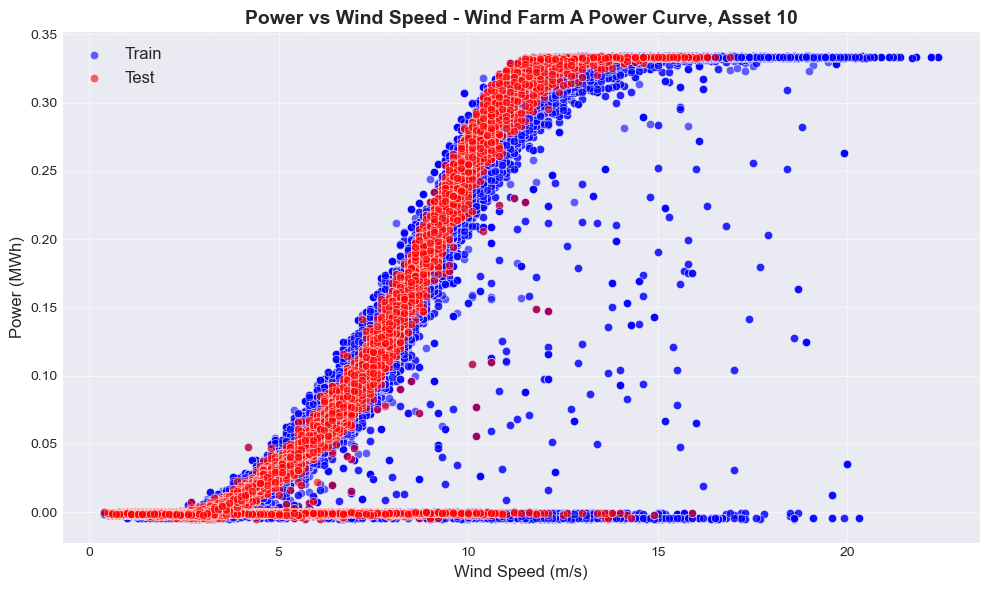

In [17]:
train_ws = wfa_wtg10_train['wind_speed_3_avg'].to_numpy()
test_ws = wfa_wtg10_test['wind_speed_3_avg'].to_numpy()
train_power = wfa_wtg10_train['sensor_50_mwh'].to_numpy()
test_power = wfa_wtg10_test['sensor_50_mwh'].to_numpy()

plt.figure(figsize=(10, 6))
plt.scatter(train_ws, train_power, color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.scatter(test_ws, test_power, color='red', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title('Power vs Wind Speed - Wind Farm A Power Curve, Asset 10', fontsize=14, fontweight='bold')
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power (MWh)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(['Train', 'Test'], fontsize=12)
plt.tight_layout()
plt.show()

The two datasets seem to follow a similar power curve, which is probably a good sign there is some predictive power since the test dataset is going to be following the training dataset.

In [18]:
# convert the columns after 
y_train = wfa_wtg10_train['status_type_id'].to_numpy()
y_test = wfa_wtg10_test['status_type_id'].to_numpy()

cols_to_drop = ['time_stamp', 'asset_id', 'id', 'train_test', 'status_type_id', 'fault_status']
X_train = wfa_wtg10_train.drop(cols_to_drop).to_numpy()
X_test = wfa_wtg10_test.drop(cols_to_drop).to_numpy()

In [19]:
print("The shape of X_train is: ", X_train.shape)
print("The shape of y_train is: ", y_train.shape)
print("The shape of X_test is: ", X_test.shape)
print("The shape of y_test is: ", y_test.shape)

The shape of X_train is:  (260339, 83)
The shape of y_train is:  (260339,)
The shape of X_test is:  (13874, 83)
The shape of y_test is:  (13874,)


In [20]:
wfa_wtg10_train.drop(cols_to_drop).drop('event_id').head()

sensor_0_avg,sensor_1_avg,sensor_2_avg,wind_speed_3_avg,wind_speed_4_avg,wind_speed_3_max,wind_speed_3_min,wind_speed_3_std,sensor_5_avg,sensor_5_max,sensor_5_min,sensor_5_std,sensor_6_avg,sensor_7_avg,sensor_8_avg,sensor_9_avg,sensor_10_avg,sensor_11_avg,sensor_12_avg,sensor_13_avg,sensor_14_avg,sensor_15_avg,sensor_16_avg,sensor_17_avg,sensor_18_avg,sensor_18_max,sensor_18_min,sensor_18_std,sensor_19_avg,sensor_20_avg,sensor_21_avg,sensor_22_avg,sensor_23_avg,sensor_24_avg,sensor_25_avg,sensor_26_avg,reactive_power_27_avg,…,power_29_max,power_29_min,power_29_std,power_30_avg,power_30_max,power_30_min,power_30_std,sensor_31_avg,sensor_31_max,sensor_31_min,sensor_31_std,sensor_32_avg,sensor_33_avg,sensor_34_avg,sensor_35_avg,sensor_36_avg,sensor_37_avg,sensor_38_avg,sensor_39_avg,sensor_40_avg,sensor_41_avg,sensor_42_avg,sensor_43_avg,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52_avg,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg,sensor_50_mwh
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20.0,265.7,19.4,2.6,2.6,4.3,1.0,0.4,24.0,24.1,24.0,0.0,30.0,35.0,44.0,35.0,31.0,39.0,39.0,30.0,32.0,34.0,34.0,35.0,203.7,224.1,166.3,13.5,24.0,31.0,32.0,0.6,12.5,10.5,13.0,50.0,0.0,…,0.017073,0.0,0.003171,-0.004,-0.003317,-0.013902,0.001707,-0.005707,-10.5,-25.4,2.1,401.6,399.7,398.1,31.0,32.0,32.0,69.0,70.0,64.0,49.0,246.3,29.0,-1371.0,0.0,0.0,-1946.0,0.0,0.0,-1371.0,-1946.0,1.8,2.0,0.0,0.2,23.0,-0.001371
20.0,244.9,-11.8,2.6,2.6,4.9,0.7,0.5,24.0,24.1,24.0,0.0,30.0,35.0,43.0,35.0,31.0,39.0,39.0,30.0,32.0,34.0,34.0,34.0,200.2,224.1,168.0,15.0,24.0,31.0,32.0,0.6,11.9,9.8,12.6,50.0,0.0,…,0.01322,0.0,0.002732,-0.003854,-0.003268,-0.012098,0.001756,-0.005415,-10.5,-15.4,0.9,400.3,397.8,396.6,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,29.0,-1309.0,0.0,0.0,-1850.0,0.0,0.0,-1309.0,-1850.0,1.8,2.0,1.5,0.1,23.0,-0.001309
20.0,299.5,42.7,2.5,2.5,4.2,0.6,0.5,24.0,24.0,21.6,0.1,30.0,35.0,42.0,35.0,31.0,38.0,39.0,30.0,31.0,34.0,34.0,34.0,202.8,224.4,148.2,23.6,24.0,30.0,31.0,0.6,12.1,10.2,12.8,50.0,0.0,…,0.007415,0.0,0.000244,-0.004,-0.003268,-0.012341,0.001902,-0.005415,-10.6,-15.4,0.9,400.0,398.3,396.5,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1349.0,0.0,0.0,-1851.0,0.0,0.0,-1349.0,-1851.0,1.6,2.0,0.0,0.7,23.0,-0.001349
20.0,280.2,23.5,2.5,2.5,3.8,0.6,0.4,24.0,24.1,24.0,0.0,30.0,35.0,41.0,35.0,31.0,38.0,39.0,30.0,31.0,34.0,34.0,34.0,198.3,212.4,170.4,12.0,24.0,30.0,31.0,0.6,11.8,9.9,12.3,50.0,0.0,…,0.0,0.0,0.0,-0.003854,-0.003268,-0.012439,0.00161,-0.005317,-10.4,-15.3,0.8,398.3,397.0,395.0,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1326.0,0.0,0.0,-1824.0,0.0,0.0,-1326.0,-1824.0,1.7,1.9,1.5,0.1,23.0,-0.001326
20.0,281.1,24.3,2.7,2.7,4.2,0.9,0.3,24.0,24.0,24.0,0.0,30.0,35.0,40.0,35.0,31.0,38.0,39.0,30.0,31.0,33.0,34.0,34.0,217.4,233.4,205.2,7.9,24.0,30.0,31.0,0.6,11.9,10.0,12.3,50.0,0.0,…,0.007951,0.0,0.000439,-0.003854,-0.003268,-0.012439,0.001707,-0.005366,-10.4,-15.3,0.9,399.1,397.9,395.9,31.0,32.0,32.0,69.0,70.0,64.0,49.0,256.8,28.0,-1324.0,0.0,0.0,-1838.0,0.0,0.0,-1324.0,-1838.0,1.9,2.1,1.8,0.1,23.0,-0.001324


## Using b-splines to extract features

In [21]:
n_knots = 14
n = X_train.shape[0]  # number of samples
m = X_train.shape[1]
knots = np.linspace(0, 1, n_knots)
xx = np.linspace(0, 1, n)
B = feat.BSplineBasis(xx, knots, degree=3)[:,:-2]

# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
# Initialize Bcoef
Bcoef = np.zeros((m, B.shape[1]))

# Fit B-splines for each feature
for i in range(m):
    Bcoef[i, :] = lsqr(B, X_scaled[:, i])[0]

In [22]:
X_reconstructed = B @ Bcoef.T
rf = RandomForestClassifier()
rf.fit(X_reconstructed, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8090673201672193


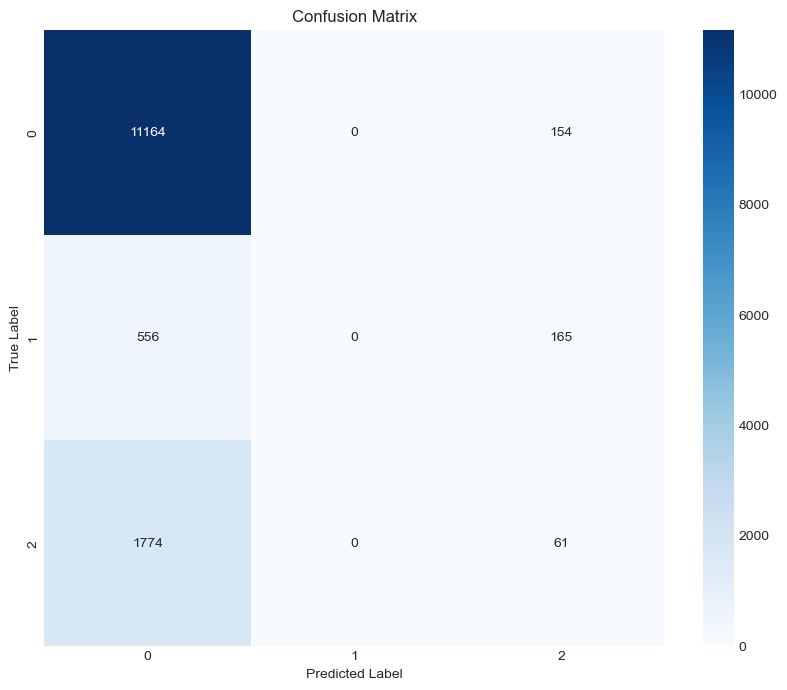

              precision    recall  f1-score   support

           0       0.83      0.99      0.90     11318
           3       0.00      0.00      0.00       721
           5       0.16      0.03      0.06      1835

    accuracy                           0.81     13874
   macro avg       0.33      0.34      0.32     13874
weighted avg       0.70      0.81      0.74     13874

Overall Accuracy: 0.81


In [23]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

# Print overall accuracy
accuracy = (y_test == y_pred).mean()
print(f"Overall Accuracy: {accuracy:.2f}")

In [24]:
importance = rf.feature_importances_
idx = np.argsort(importance)[::-1]
feature_names = [f"Feature {i}" for i in range(len(importance))]

print("Feature ranking:")
for f in range(len(importance)):
    print("%d. %s (%f)" % (f + 1, feature_names[idx[f]], importance[idx[f]]))

Feature ranking:
1. Feature 44 (0.026459)
2. Feature 3 (0.025350)
3. Feature 40 (0.024544)
4. Feature 20 (0.020910)
5. Feature 13 (0.020703)
6. Feature 12 (0.018324)
7. Feature 38 (0.017976)
8. Feature 48 (0.015847)
9. Feature 82 (0.015336)
10. Feature 2 (0.014980)
11. Feature 7 (0.014139)
12. Feature 28 (0.014081)
13. Feature 75 (0.014030)
14. Feature 34 (0.013383)
15. Feature 17 (0.013234)
16. Feature 81 (0.013117)
17. Feature 16 (0.013015)
18. Feature 67 (0.012997)
19. Feature 11 (0.012974)
20. Feature 47 (0.012956)
21. Feature 80 (0.012852)
22. Feature 72 (0.012730)
23. Feature 39 (0.012696)
24. Feature 70 (0.012696)
25. Feature 15 (0.012676)
26. Feature 49 (0.012556)
27. Feature 8 (0.012477)
28. Feature 43 (0.012447)
29. Feature 59 (0.012252)
30. Feature 9 (0.012215)
31. Feature 37 (0.012172)
32. Feature 57 (0.012166)
33. Feature 68 (0.012014)
34. Feature 19 (0.012012)
35. Feature 58 (0.012008)
36. Feature 42 (0.011967)
37. Feature 41 (0.011907)
38. Feature 6 (0.011834)
39. Featur

In [25]:
# Number of B-spline coefficients per original feature
n_coef_per_feature = 12

# Original feature names (replace with your actual feature names)
original_feature_names = wfa_wtg10_train.drop(cols_to_drop).columns

# Function to map B-spline coefficient index to original feature index
def map_to_original_feature(bspline_index):
    return bspline_index // n_coef_per_feature

df_importances = pd.DataFrame({
    'feature': range(len(importance)),
    'importance': importance
})

# Sort by importance
df_importances = df_importances.sort_values('importance', ascending=False)

# Translate and aggregate importance
translated_importance = {}
for bspline_index, importance in zip(df_importances['feature'], df_importances['importance']):
    original_index = map_to_original_feature(bspline_index)
    original_name = original_feature_names[original_index]
    if original_name not in translated_importance:
        translated_importance[original_name] = 0
    translated_importance[original_name] += importance

# Sort by aggregated importance
sorted_importance = sorted(translated_importance.items(), key=lambda x: x[1], reverse=True)

# Print the results
print("Translated and aggregated feature importance:")
for name, importance in sorted_importance:
    print(f"{name}: {importance:.6f}")

Translated and aggregated feature importance:
sensor_2_avg: 0.177261
event_id: 0.161411
sensor_0_avg: 0.154016
wind_speed_3_avg: 0.142612
wind_speed_4_avg: 0.123476
sensor_1_avg: 0.122168
wind_speed_3_max: 0.119055


## Using the Group_Lasso

In [21]:
# drop nulls in wfa_df
wfa_df = wfa_df.drop_nulls()

In [22]:
# Split the dataset into train and test sets based on "train_test" column
train_df = wfa_df.filter(pl.col('train_test') == 'train')
test_df = wfa_df.filter(pl.col('train_test') == 'prediction')

# use cols_to_drop to drop columns from train_df and test_df to create X_train, y_train, X_test, y_test
X_train = train_df.drop(cols_to_drop).drop(['event_id'])
y_train = train_df['fault_status']
X_test = test_df.drop(cols_to_drop).drop(['event_id'])
y_test = test_df['fault_status']

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# number of samples in the wfa_df dataset
n = wfa_df.shape[0]
# number of features in the wfa_df dataset
m = X_train.shape[1] 
print("n = ", n, "m = ", m)
# number of turbines in the wfa_df dataset
n_turbines = len(wfa_df['asset_id'].unique())

# Define groups (each turbine's features are grouped together)
features_per_turbine = m // n_turbines
groups = np.repeat(np.arange(n_turbines), features_per_turbine)
# Ensure the groups array matches the number of features
if len(groups) < m:
    groups = np.concatenate([groups, np.full(m - len(groups), n_turbines)])
print("Length of groups: ", len(groups))

n =  1196727 m =  81
Length of groups:  81


In [24]:
groups

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5])

In [25]:
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1146138, 81)
y_train shape: (1146138,)
X_test shape: (50589, 81)
y_test shape: (50589,)


In [31]:
log_group_lasso = LogisticGroupLasso(
    groups=groups,
    group_reg=0.01,  # Group regularization parameter (tune this)
    l1_reg=0.01,    # L1 regularization parameter (tune this)
    tol=1e-3,
    warm_start=False,
    random_state=42,
    supress_warning=True,
)

log_group_lasso.fit(X_train_scaled, y_train)
y_pred = log_group_lasso.predict(X_test_scaled)
y_pred_proba = log_group_lasso.predict_proba(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7752673506098163


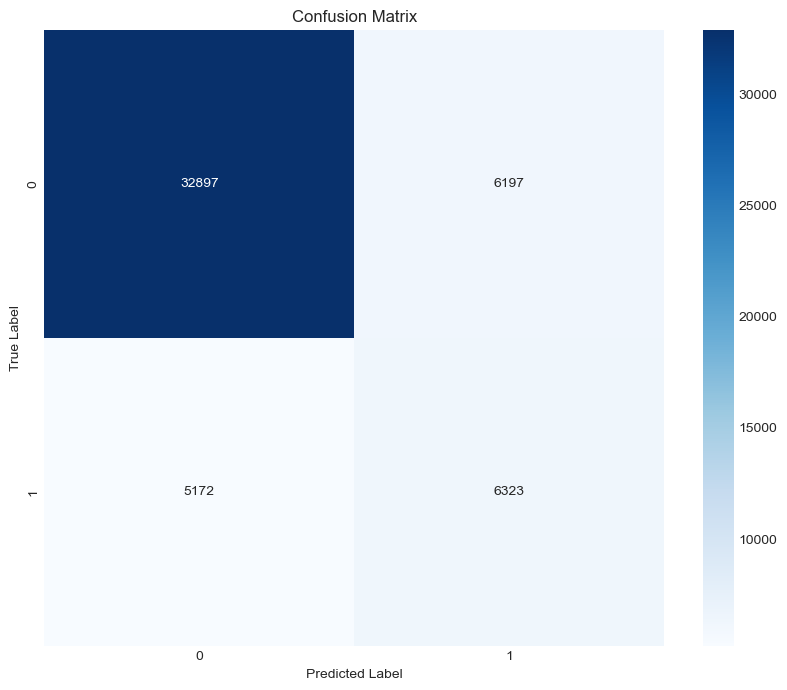

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     39094
           1       0.51      0.55      0.53     11495

    accuracy                           0.78     50589
   macro avg       0.68      0.70      0.69     50589
weighted avg       0.78      0.78      0.78     50589



In [32]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

## Group Lasso with CV

being more intentional about the groups i want to form. Previously, I grouped by turbines, which may capture correlations and features from the same turbine, assuming they are more related and should be selected or dropped together. It's a reasonable starting point, especially if you believe there might be turbine-specific patterns or differences.

In [26]:
feature_descriptions = wind_farm_a['feature_description'].collect()
feature_descriptions

sensor_name,statistics_type,description,unit,is_angle,is_counter
str,str,str,str,bool,bool
"""sensor_0""","""average""","""Ambient temperature""","""°C""",false,false
"""sensor_1""","""average""","""Wind absolute direction""","""°""",true,false
"""sensor_2""","""average""","""Wind relative direction""","""°""",true,false
"""wind_speed_3""","""maximum,minimum,average,std_de…","""Windspeed""","""m/s""",false,false
"""wind_speed_4""","""average""","""Estimated windspeed""","""m/s""",false,false
…,…,…,…,…,…
"""sensor_49""","""average""","""Reactive power - generator con…","""VArh""",false,false
"""sensor_50""","""average""","""Total active power""","""Wh""",false,false
"""sensor_51""","""average""","""Total reactive power""","""VArh""",false,false


Next, I want to group by feature type. Grouping features by their type (e.g., ambient conditions, temperatures, operational metrics) can capture domain knowledge about which features might be related in terms of their predictive power.

In [27]:
cols = X_train.columns

In [28]:
# Create groups array
feature_groups = feat.create_group_dict("feature")
group_array = feat.groups_array("feature", X_train)

In [29]:
group_array

array([0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       5, 0, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 0])

In [37]:
log_group_lasso = LogisticGroupLasso(
    groups=group_array,
    group_reg=0.01,  # Group regularization parameter (tune this)
    l1_reg=0.01,    # L1 regularization parameter (tune this)
    tol=1e-3,
    warm_start=False,
    random_state=42,
    supress_warning=True,
)

log_group_lasso.fit(X_train_scaled, y_train)
y_pred = log_group_lasso.predict(X_test_scaled)
y_pred_proba = log_group_lasso.predict_proba(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7776196406333392


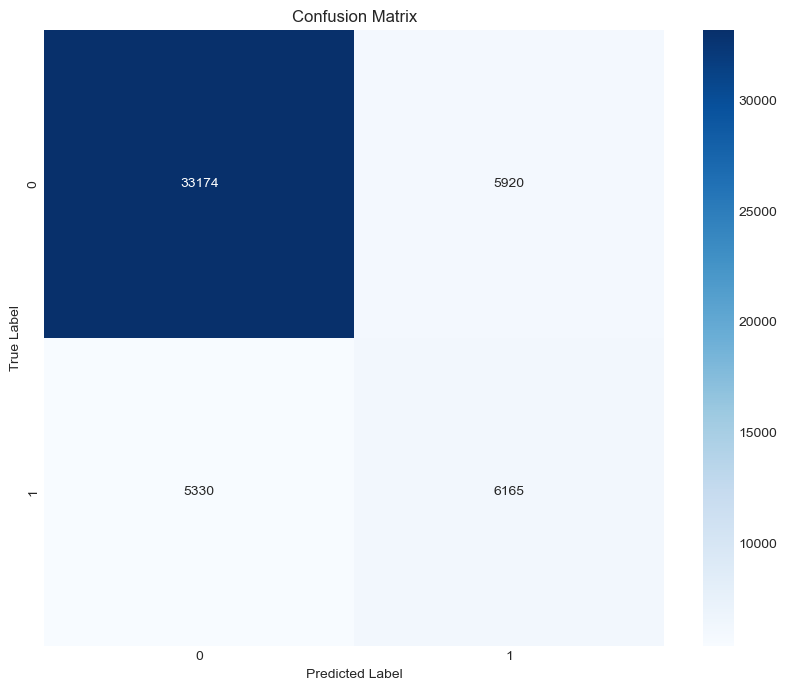

              precision    recall  f1-score   support

           0       0.86      0.85      0.86     39094
           1       0.51      0.54      0.52     11495

    accuracy                           0.78     50589
   macro avg       0.69      0.69      0.69     50589
weighted avg       0.78      0.78      0.78     50589



In [38]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

### Group Lasso with Dimensionality Reduction: Functional Principal Components

Shape of PC scores: (10, 1146138)
Explained variance ratio: [9.97030385e-01 2.91953547e-03 3.55407108e-05 8.40110879e-06
 2.70948873e-06 1.48936488e-06 9.04531675e-07 5.01730364e-07
 1.72425146e-07 1.27679089e-07]


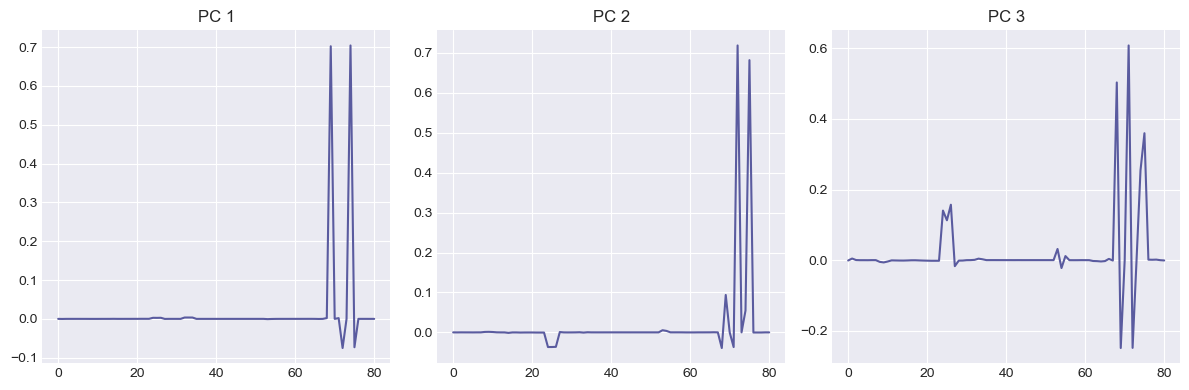

In [33]:
X_train_np = X_train.to_numpy().T  # Transpose to get shape (M, n)

# Center the data
X_centered = X_train_np - np.mean(X_train_np, axis=1, keepdims=True)

# Compute the covariance matrix
cov_matrix = np.cov(X_centered)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Project data onto principal components
n_components = 10  # Choose the number of components you want
pc_scores = eigenvectors[:, :n_components].T @ X_centered

print("Shape of PC scores:", pc_scores.shape)
print("Explained variance ratio:", eigenvalues[:n_components] / np.sum(eigenvalues))

# Plot the first few principal components
plt.figure(figsize=(12, 4))
for i in range(min(3, n_components)):
    plt.subplot(1, 3, i+1)
    plt.plot(eigenvectors[:, i])
    plt.title(f"PC {i+1}")
plt.tight_layout()
plt.show()

# Convert PC scores back to Polars DataFrame if needed
pc_scores_df = pl.DataFrame(pc_scores.T, schema=[f"PC_{i+1}" for i in range(n_components)])

In [42]:
data

PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
-134027.242951,7463.392054,-1325.331689,138.230449,-466.881734,-24.597298,11.944264,78.013152,13.902525,-19.460629,0
-133990.286928,7526.379601,-1186.019397,169.743387,-448.776545,-27.675375,2.044873,70.149036,7.107825,-22.232223,0
-134018.52381,7525.734114,-1219.874736,167.98154,-409.559448,-25.242322,-2.248229,109.851781,16.025721,-26.024864,0
-134004.178619,7543.300508,-1174.725361,181.990321,-419.951131,-7.532523,7.223604,96.276907,9.074874,-24.162185,0
-134001.566254,7531.564885,-1176.166802,143.189737,-440.22983,10.549695,7.547061,96.03648,3.616686,-22.061876,0
…,…,…,…,…,…,…,…,…,…,…
159241.873425,-9148.779504,-541.387128,235.189108,67.006051,-51.576952,35.957917,224.972323,32.145679,-30.001843,0
149709.455578,-8624.369168,-467.957313,208.869165,69.21323,-67.967653,10.448397,215.599002,48.676738,-33.841472,0
152754.375081,-8034.308911,-423.206155,166.960037,42.307484,-16.105878,23.827495,220.188109,32.663477,-28.615295,0


In [43]:
data = pc_scores_df.with_columns(pl.Series(name="y", values=y_train.to_numpy()))
X = data.drop("y")
y = data.select("y").to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
groups = [0] * pc_scores.shape[0]
cumulative_variance = np.cumsum(explained_variance_ratio)
for i, cum_var in enumerate(cumulative_variance):
    if cum_var > 0.99:  # Adjust this threshold as needed
        groups[i:] = [1] * (len(groups) - i)
        break
    
log_group_lasso = LogisticGroupLasso(
    groups=groups,
    group_reg=0.01,  # Group regularization parameter (tune this)
    l1_reg=0.01,    # L1 regularization parameter (tune this)
    tol=1e-3,
    warm_start=False,
    random_state=42,
    supress_warning=True,
)

log_group_lasso.fit(X_train_scaled, y_train)
y_pred = log_group_lasso.predict(X_test_scaled)
y_pred_proba = log_group_lasso.predict_proba(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8259593068909558


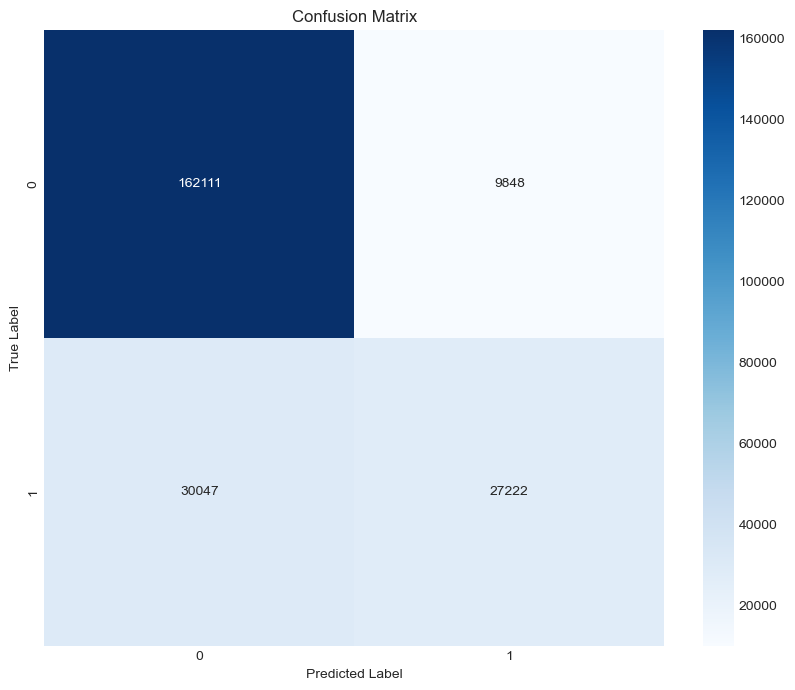

              precision    recall  f1-score   support

           0       0.84      0.94      0.89    171959
           1       0.73      0.48      0.58     57269

    accuracy                           0.83    229228
   macro avg       0.79      0.71      0.73    229228
weighted avg       0.82      0.83      0.81    229228



In [44]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

In [45]:
lambdas, _, _ = lm.lasso_path(X_train_scaled, y_train)
n_lambdas = 10  # or another suitable number
lambdas = np.logspace(np.log10(lambdas.max()), np.log10(lambdas.min()), n_lambdas)

glreg = LogisticGroupLasso(
    groups=groups,
    group_reg=0,
    l1_reg=0,
    fit_intercept=True,
    tol=1e-3,
    warm_start=True,
    random_state=42,
    supress_warning=True,
)
from sklearn.model_selection import RandomizedSearchCV

CV = RandomizedSearchCV(
    glreg, 
    param_distributions={"group_reg": lambdas},
    n_iter=20,  # number of parameter settings sampled
    scoring="neg_mean_squared_error", 
    verbose=1,
    n_jobs=-1  # use all available cores
)

CV.fit(X_train_scaled, y_train)
coef = CV.best_estimator_.coef_
lam = CV.best_params_["group_reg"]
print("Best lambda:", lam)
print("Shape of coefficient matrix:", coef.shape)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best lambda: 0.0001882157172813199
Shape of coefficient matrix: (10, 2)


In [46]:
# Predict on test set
y_pred = CV.predict(X_test_scaled)
y_pred_proba = CV.predict_proba(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8525529167466452


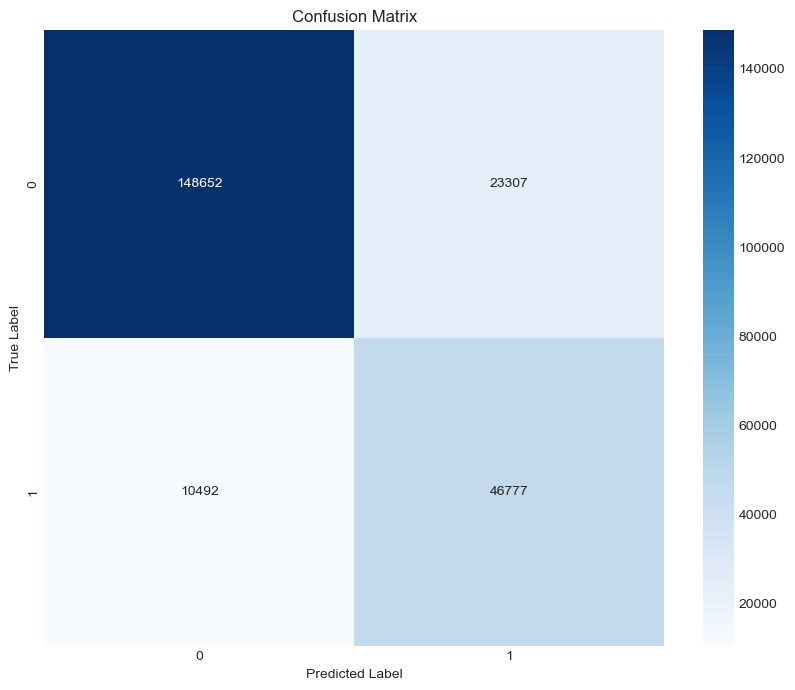

              precision    recall  f1-score   support

           0       0.93      0.86      0.90    171959
           1       0.67      0.82      0.73     57269

    accuracy                           0.85    229228
   macro avg       0.80      0.84      0.82    229228
weighted avg       0.87      0.85      0.86    229228



In [48]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))